In [3]:
import sys
sys.path.append('C:\Users\micmitch\Documents\UBC\GIF\Programs\SimPEG')
import SimPEG as simpeg
# import simpegDCIP as DC

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [80]:


# Minimum cell size in each direction
dx = 1.
dy = 1.
dz = 1.

# Number of core cells in each direction
nCoreX = 91.
nCoreY = 41.
nCoreZ = 41.

nPadX = 7
nPadY = 7
nPadZ = 7


# Cell widths
# hx = [(dx,nCoreX)]
# hy = [(dy,nCoreY)]
# hz = [(dz,nCoreZ)]
hx = [(dx,nPadX, -1.3),(dx,nCoreX),(dx,nPadX, 1.3)]
hy = [(dy,nPadY, -1.3),(dy,nCoreY),(dy,nPadY, 1.3)]
hz = [(dz,nPadZ, -1.3),(dz,nCoreZ),(dz,nPadZ, 1.3)]

# Calculate X padding distance
hPadX = np.zeros([nPadX+1,1])
hPadX[0] = dx
for i in range (1,nPadX+1):
    hPadX[i] = hPadX[i-1]*1.3

xPadDist = np.max(np.cumsum(hPadX[1:nPadX+1]))

# Calculate Y padding distance
hPadY = np.zeros([nPadY+1,1])
hPadY[0] = dy
for i in range (1,nPadY+1):
    hPadY[i] = hPadY[i-1]*1.3

yPadDist = np.max(np.cumsum(hPadY[1:nPadY+1]))

# Calculate Z padding distance
hPadZ = np.zeros([nPadZ+1,1])
hPadZ[0] = dz
for i in range (1,nPadZ+1):
    hPadZ[i] = hPadZ[i-1]*1.3

zPadDist = np.max(np.cumsum(hPadZ[1:nPadZ+1]))

# Desired Core mesh origin (Bottom SW corner)
x0_core = -20.5
y0_core = -20.5
z0_core = -20.5

# Mesh origin (Bottom SW corner)
x0 = x0_core - xPadDist
y0 = y0_core - yPadDist
z0 = z0_core - zPadDist


In [81]:
mesh = simpeg.Mesh.TensorMesh([hx, hy, hz],[x0,y0,z0])
print mesh

  ---- 3-D TensorMesh ----  
   x0: -43.36
   y0: -43.36
   z0: -43.36
  nCx: 105
  nCy: 55
  nCz: 55
   hx: 6.27, 4.83, 3.71, 2.86, 2.20, 1.69, 1.30, 91*1.00, 1.30, 1.69, 2.20, 2.86, 3.71, 4.83, 6.27
   hy: 6.27, 4.83, 3.71, 2.86, 2.20, 1.69, 1.30, 41*1.00, 1.30, 1.69, 2.20, 2.86, 3.71, 4.83, 6.27
   hz: 6.27, 4.83, 3.71, 2.86, 2.20, 1.69, 1.30, 41*1.00, 1.30, 1.69, 2.20, 2.86, 3.71, 4.83, 6.27


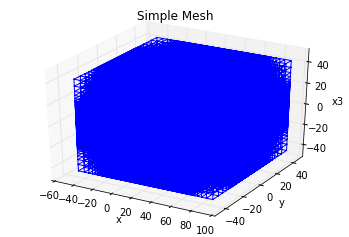

In [82]:
mesh.plotGrid()
plt.title('Simple Mesh')
plt.xlabel('x')
plt.ylabel('y')
# ax.set_zlabel('z')

In [83]:
nCell = mesh.nC
print nCell

317625


In [84]:
# Create synthetic model
sigmaFull = 5e-3
sigma = np.ones(mesh.nC)*sigmaFull

# Add tunnel
sigmaTunnel = 1e-8

t1_1 = np.array([-20.5,1.5,-1.5]) # Bottom NW corner
t1_2 = np.array([70,-1.5,1.5]) # Top SE corner
tunnel1 = simpeg.Utils.ModelBuilder.getIndicesBlock(t1_1,t1_2, mesh.gridCC)
sigma[tunnel1] = sigmaTunnel

# Add blocks
CondBlockSigma = 10;
ResBlockSigma = 5e-5;

# block 1 (North)
b1_1 = [7.5, 11.5, -5.5];
b1_2 = [12.5, 6.5, -0.5];

# block 2 (Above)
b2_1 = [17.5, -0.5, 6.5];
b2_2 = [22.5, -5.5, 11.5];

# block 3 (South)
b3_1 = [27.5, -6.5, 0.5];
b3_2 = [32.5, -11.5, 5.5];

# block 4 (Below)
b4_1 = [37.5, 5.5, -11.5];
b4_2 = [42.5, 0.5, -6.6];

blk1 = simpeg.Utils.ModelBuilder.getIndicesBlock(b1_1,b1_2, mesh.gridCC)
sigma[blk1] = CondBlockSigma
blk2 = simpeg.Utils.ModelBuilder.getIndicesBlock(b2_1,b2_2, mesh.gridCC)
sigma[blk2] = CondBlockSigma
blk3 = simpeg.Utils.ModelBuilder.getIndicesBlock(b3_1,b3_2, mesh.gridCC)
sigma[blk3] = ResBlockSigma
blk4 = simpeg.Utils.ModelBuilder.getIndicesBlock(b4_1,b4_2, mesh.gridCC)
sigma[blk4] = ResBlockSigma

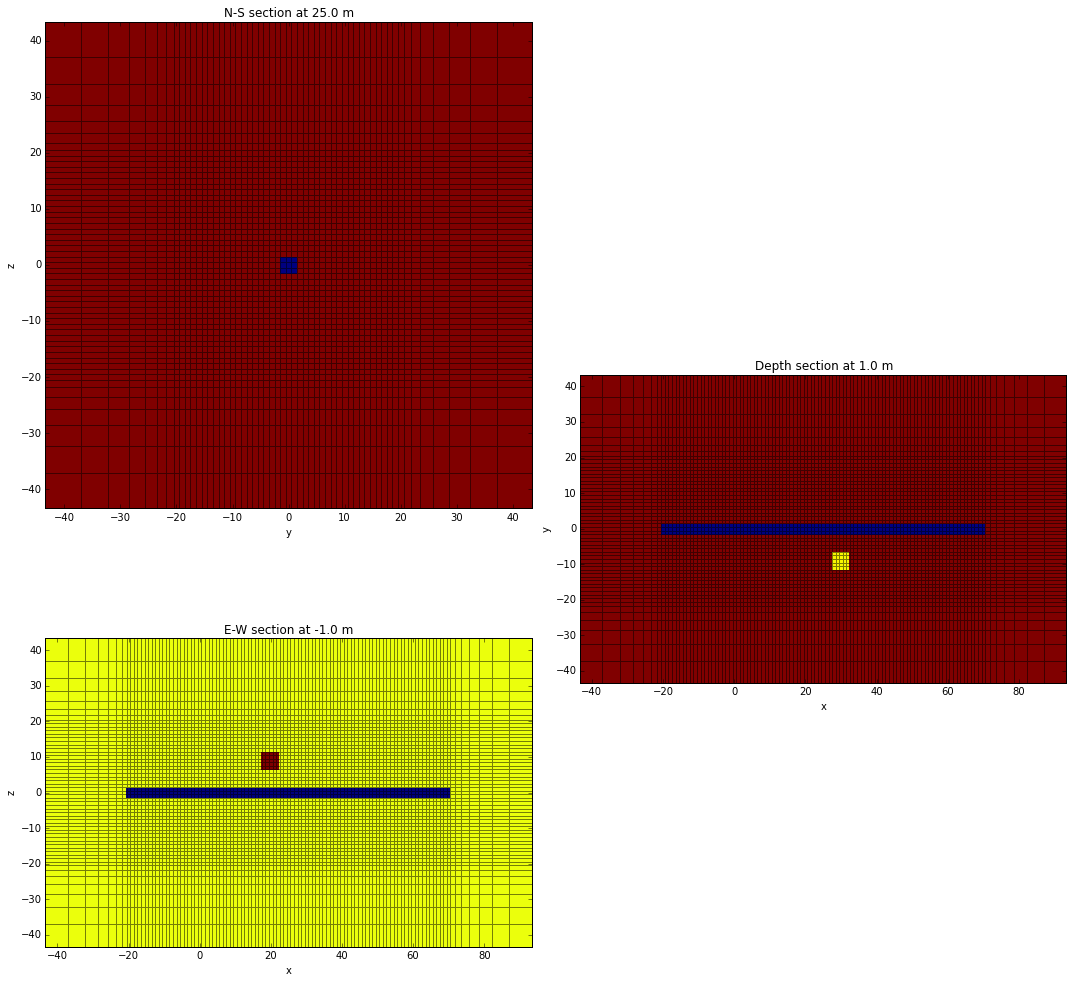

In [61]:
xSliceInd = 52
ySliceInd = 26
zSliceInd = 28
# xSliceInd = int(mesh.nCx/2)
# print xSliceInd
# ySliceInd = int(mesh.nCy/2)
# print ySliceInd
# zSliceInd = int(mesh.nCz/2)
# print zSliceInd


gs = gridspec.GridSpec(4, 4)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax1 = plt.subplot(gs[0:2, 0:2])
# ax = plt.subplot(3,1,1, aspect='equal')
mesh.plotSlice(np.log10(sigma), ax =ax1, normal='X', ind=xSliceInd, grid=True)
ax1.set_title('N-S section at '+str(mesh.vectorCCx[xSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')

ax2 = plt.subplot(gs[2:4, 0:2])
# ax = plt.subplot(3,1,2, aspect='equal')
mesh.plotSlice(np.log10(sigma), ax =ax2, normal='Y', ind=ySliceInd, grid=True)
ax2.set_title('E-W section at '+str(mesh.vectorCCy[ySliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')

ax3 = plt.subplot(gs[0:4, 2:4])
# ax = plt.subplot(3,1,3, aspect='equal')
mesh.plotSlice(np.log10(sigma), ax =ax3, normal='Z', ind=zSliceInd, grid=True)
ax3.set_title('Depth section at '+str(mesh.vectorCCz[zSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()


# How would I plot these using a log colorscale (to see tunnel cells) and insert a colorbar?

In [85]:
# Define electrode locations

nRings = 6
nElecPerRing = 4

# ring1  =  np.array([[ 0, 0, 2], [  0, -2, 0], [  0, 0, -2], [  0, 2, 0]])
# ring2  =  np.array([[10, 0, 2], [ 10, -2, 0], [ 10, 0, -2], [ 10, 2, 0]])
# ring3  =  np.array([[20, 0, 2], [ 20, -2, 0], [ 20, 0, -2], [ 20, 2, 0]])
# ring4  =  np.array([[30, 0, 2], [ 30, -2, 0], [ 30, 0, -2], [ 30, 2, 0]])
# ring5  =  np.array([[40, 0, 2], [ 40, -2, 0], [ 40, 0, -2], [ 40, 2, 0]])
# ring6  =  np.array([[50, 0, 2], [ 50, -2, 0], [ 50, 0, -2], [ 50, 2, 0]])

rings  =  np.array([[[ 0, 0, 2], [  0, -2, 0], [  0, 0, -2], [  0, 2, 0]],
[[10, 0, 2], [ 10, -2, 0], [ 10, 0, -2], [ 10, 2, 0]],
[[20, 0, 2], [ 20, -2, 0], [ 20, 0, -2], [ 20, 2, 0]],
[[30, 0, 2], [ 30, -2, 0], [ 30, 0, -2], [ 30, 2, 0]],
[[40, 0, 2], [ 40, -2, 0], [ 40, 0, -2], [ 40, 2, 0]],
[[50, 0, 2], [ 50, -2, 0], [ 50, 0, -2], [ 50, 2, 0]]])

elecLoc = rings.reshape((nRings*nElecPerRing, 3))


In [86]:
# Create electrode sequence

# Combinations of electrodes for dipole-dipole measurements

nElec = elecLoc.shape[0]
print nElec
elecID = np.arange(0,nElec,1)
print elecID

Tx_ElecInd = []
for ii in elecID[0:-1]:
    for jj in np.arange(ii+1,nElec,1):
       Tx_ElecInd.append([ii , jj])
    
# nTx = len(Tx_ElecInd) 
nTx = np.array(Tx_ElecInd).shape[0]


dataDict = {}
# nRxList = []
# Iterate over Tx and select possible Rx for each
for nr, Tx in enumerate(Tx_ElecInd):
#     print nr, Tx
    useableRxElecs = np.setdiff1d(elecID,Tx)
    RxPairs = itertools.combinations(useableRxElecs,2) # n choose k combinations
    
    # Extract data from combinations object
    RxPairList = []
    for ii in RxPairs:
        RxPairList.append(tuple(ii))

    RxPairArray = np.array(RxPairList)
    nRx = RxPairArray.shape[0]
#     nRxList.append([nRx])
    
    A = Tx[0]*np.ones((nRx,1))
    B = Tx[1]*np.ones((nRx,1))
    dataArray = np.hstack([A,B,RxPairArray])
    dataDict[nr] = dataArray
    

# nRxList
    
    
    
#        TxLoc = cat(1,TxLoc,[elecLocRing(Tx_ElecInd(ii,1),:),elecLocRing(Tx_ElecInd(ii,2),:)]);
#        RxLoc = [elecLocRing(RxPairs(:,1),:) elecLocRing(RxPairs(:,2),:)];
#        nRx = size(RxLoc,1);
# %        TxID = TxInd*ones(nRx,1);
#        TxID = ii*ones(nRx,1);
#        DC = zeros(nRx,1);
#        %Make data matrix
#        DataMatrix{ii} = [TxID RxLoc DC];
#        %Create data object
# %        dataHead = {'TXIND','XM','YM','ZM','XN','YN','ZN','DC'};
#        SynthData = DC3Ddata(MOS,dataHead,DataMatrix{ii});
#        SynthData.setioHeadInd([1,2,3,4,5,6,7,8,0]);
#        % Set Tx
#        SynthData.setTx(TxLoc);
#        % Output locations file
#        fileName = sprintf('./TxLocFiles/Straight_Tunnel_Ring_Tx%d.loc', ii);
#        DCoctreeforward.writeLoc(SynthData,fileName);
#        DataFull = cat(1,DataFull,DataMatrix{ii});
#        fprintf('Tx%i data matrix created.\n',ii);
    

24
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


nTx = 276


(63756L, 4L)

In [99]:
 # Create Tx and Rx data objects for the survey object

FullElecSeqList = []
for Tx in dataDict.keys():
#     print Tx
    FullElecSeqList.append(dataDict[Tx])

# print "nTx = %i" % (nTx)

FullElecSeqArray = np.array(FullElecSeqList)
FullElecSeq = FullElecSeqArray.reshape(nTx*nRx,4)
FullElecSeq.shape

nData = FullElecSeq.shape[0]
# print nData

AIds = FullElecSeq[:,0]
BIds = FullElecSeq[:,1]
MIds = FullElecSeq[:,2]
NIds = FullElecSeq[:,3]

ALoc = np.zeros([nData,3])
BLoc = np.zeros([nData,3])
MLoc = np.zeros([nData,3])
NLoc = np.zeros([nData,3])

for ii in range(0, nElec-1):
    AInd = np.where(AIds == ii)
    ALoc[AInd,:] = elecLoc[ii,:]
    
    BInd = np.where(BIds == ii)
    BLoc[BInd,:] = elecLoc[i,:]
    
    MInd = np.where(MIds == ii)
    MLoc[MInd,:] = elecLoc[i,:]
    
    NInd = np.where(NIds == ii)
    NLoc[NInd,:] = elecLoc[ii,:]


RxData = DC.RxDipole(MLoc, NLoc)
TxData = DC.SrcDipole([RxData], [ALoc],[BLoc])

In [100]:
# Assign TxData to DC survey object
survey = DC.SurveyDC([TxData])
# Assign mesh to probelm object
problem = DC.ProblemDC_CC(mesh)
# Pair survey with problem
problem.pair(survey)

In [101]:
try:
    from pymatsolver import MumpsSolver
    problem.Solver = MumpsSolver
except Exception, e:
    problem.Solver = SolverLU



In [19]:
sigmaBackground = np.ones(mesh.nC)*sigmaFull

# %%time
dataPred = survey.dpred(sigmaBackground)

TypeError: not all arguments converted during string formatting

In [ ]:
u1 = problem.fields(sigma)
u2 = problem.fields(sigmaBackground)

In [ ]:
Msig1 = Utils.sdiag(1./(mesh.aveF2CC.T*(1./sigma)))
Msig2 = Utils.sdiag(1./(mesh.aveF2CC.T*(1./sigmaBackground)))


In [ ]:
j1 = Msig1*mesh.cellGrad*u1[tx, 'phi_sol']
j2 = Msig2*mesh.cellGrad*u2[tx, 'phi_sol']

In [ ]:
us = u1-u2
js = j1-j2


In [ ]:
mesh.plotSlice(mesh.aveF2CCV*j1, vType='CCv', normal='Y', view='vec', streamOpts={"density":3, "color":'w'})
xlim(-300, 300)
ylim(-300, 0)

In [ ]:
mesh.plotSlice(mesh.aveF2CCV*js, vType='CCv', normal='Y', view='vec', streamOpts={"density":3, "color":'w'})
xlim(-300, 300)
ylim(-300, 0)

In [46]:
problem.Solver??